# Stock Data Probe

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Input / Target Data

In [4]:
# out_dir

In [5]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

In [6]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
ds.data_vars

Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

### transform data

In [7]:
stock_ = pd.read_csv(data_dir / "AAPL.csv")
stock_ = stock_.rename({"Date": "time"}, axis=1)
stock_["time"] = [pd.to_datetime(t) for t in stock_["time"]]
stock = stock_.set_index("time").to_xarray()
stock

<xarray.Dataset>
Dimensions:    (time: 10226)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-12 1980-12-15 ... 2021-07-02
Data variables:
    Open       (time) float64 0.1283 0.1222 0.1133 0.1155 ... 136.2 136.6 137.9
    High       (time) float64 0.1289 0.1222 0.1133 0.1161 ... 137.4 137.3 140.0
    Low        (time) float64 0.1283 0.1217 0.1127 0.1155 ... 135.9 135.8 137.8
    Close      (time) float64 0.1283 0.1217 0.1127 0.1155 ... 137.0 137.3 140.0
    Adj Close  (time) float64 0.1008 0.0955 0.08849 ... 137.0 137.3 140.0
    Volume     (time) int64 469033600 175884800 105728000 ... 52485800 78852600

In [8]:
test_start_date = "1998-01-01"
test_end_date = "2008-12-31"
data = stock.sel(time=slice(test_start_date, test_end_date))
data

<xarray.Dataset>
Dimensions:    (time: 2767)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-02 1998-01-05 ... 2008-12-31
Data variables:
    Open       (time) float64 0.1217 0.1473 0.1423 0.168 ... 3.09 3.122 3.07
    High       (time) float64 0.1451 0.1479 0.1786 0.1696 ... 3.129 3.145 3.134
    Low        (time) float64 0.1205 0.1356 0.1317 0.1546 ... 3.038 3.026 3.048
    Close      (time) float64 0.1451 0.1417 0.1691 0.1562 ... 3.093 3.082 3.048
    Adj Close  (time) float64 0.1248 0.1219 0.1454 0.1344 ... 2.66 2.65 2.621
    Volume     (time) int64 718110400 651873600 ... 967601600 607541200

## Convert to station_id format, copying the same data 671 times

In [9]:
stock_ds = data[["Close"]].copy()
stock_ds = stock_ds.expand_dims({"station_id": ds.station_id})

In [10]:
print(stock_ds.isel(station_id=0).Close[:10])
print(stock_ds.isel(station_id=100).Close[:10])

<xarray.DataArray 'Close' (time: 10)>
array([0.145089, 0.141741, 0.169085, 0.15625 , 0.162388, 0.162388,
       0.162946, 0.174107, 0.176339, 0.171317])
Coordinates:
    station_id  int64 1001
  * time        (time) datetime64[ns] 1998-01-02 1998-01-05 ... 1998-01-15
<xarray.DataArray 'Close' (time: 10)>
array([0.145089, 0.141741, 0.169085, 0.15625 , 0.162388, 0.162388,
       0.162946, 0.174107, 0.176339, 0.171317])
Coordinates:
    station_id  int64 21026
  * time        (time) datetime64[ns] 1998-01-02 1998-01-05 ... 1998-01-15


## Normalize data

In [11]:
# log_normalise
eps = 1e-10
log_stock = np.log(stock_ds["Close"])
stock_mean_ = log_stock.mean(dim="time")
stock_std_ = log_stock.std(dim="time")
lognorm_stock = (log_stock - stock_mean_) / stock_std_

In [12]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# quantile-transform
qt = QuantileTransformer()
scaler = StandardScaler

qt_stock = qt.fit_transform(stock_ds["Close"].isel(station_id=0).values.reshape(-1, 1))

In [13]:
# box-cox 
pt = PowerTransformer(method='box-cox', standardize=True)
boxcox_stock = pt.fit_transform(stock_ds["Close"].values.reshape(-1, 1))

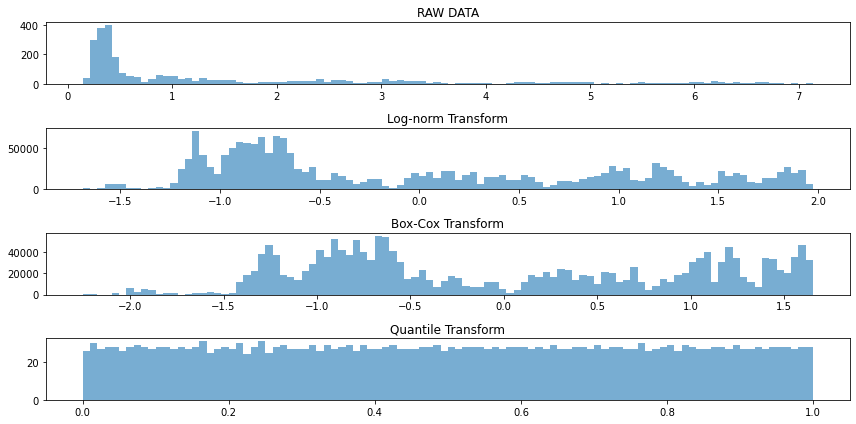

In [14]:
f, axs = plt.subplots(4, 1, figsize=(12, 6))

ax = axs[0]
ax.hist((data["Close"].values).flatten(), alpha=0.6, bins=100);
ax.set_title("RAW DATA")

ax = axs[1]
ax.hist((lognorm_stock.values).flatten(), alpha=0.6, bins=100);
ax.set_title("Log-norm Transform")

ax = axs[2]
ax.hist((boxcox_stock).flatten(), alpha=0.6, bins=100);
ax.set_title("Box-Cox Transform")

ax = axs[3]
ax.hist((qt_stock).flatten(), alpha=0.6, bins=100);
ax.set_title("Quantile Transform")

plt.tight_layout();

# Train the probes

In [15]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [16]:
quantile_transform_stock_ds = xr.ones_like(stock_ds) * qt_stock.T

In [17]:
target_ds = stock_ds
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]
target_var = "Close"

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


# all_train_test = defaultdict(dict)
print(f"** STARTING {target_var} **")
train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

train = get_time_basin_aligned_dictionary(train_dataset)

test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

test = get_time_basin_aligned_dictionary(test_dataset)

# all_train_test[target_var]["train"] = train
# all_train_test[target_var]["test"] = test

** STARTING Close **


Extracting Data: 100%|██████████| 5747/5747 [00:47<00:00, 122.03it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 1480/1480 [00:11<00:00, 125.40it/s]

Merging and reshaping arrays


In [18]:
print(f"** {target_var} **")
model, preds, errors = fit_and_predict(train, test, random_seed=100)

** Close **
-- Epoch 1
Norm: 0.17, NNZs: 17, Bias: 0.447458, T: 1324017, Avg. loss: 0.035843
Total training time: 1.19 seconds.
-- Epoch 2
Norm: 0.16, NNZs: 17, Bias: 0.447402, T: 2648034, Avg. loss: 0.035820
Total training time: 2.51 seconds.
-- Epoch 3
Norm: 0.16, NNZs: 16, Bias: 0.447095, T: 3972051, Avg. loss: 0.035818
Total training time: 3.90 seconds.
-- Epoch 4
Norm: 0.16, NNZs: 20, Bias: 0.447004, T: 5296068, Avg. loss: 0.035818
Total training time: 5.23 seconds.
Convergence after 4 epochs took 5.34 seconds


Calculating Errors: 100%|██████████| 669/669 [00:08<00:00, 81.56it/s, 107001]


# Explore Results

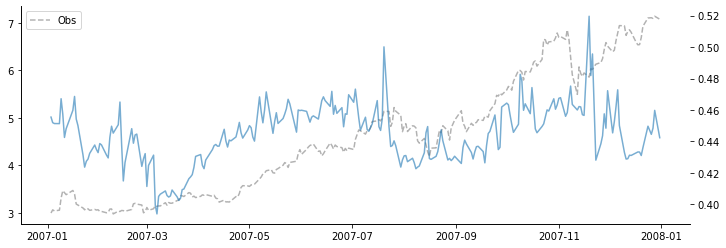

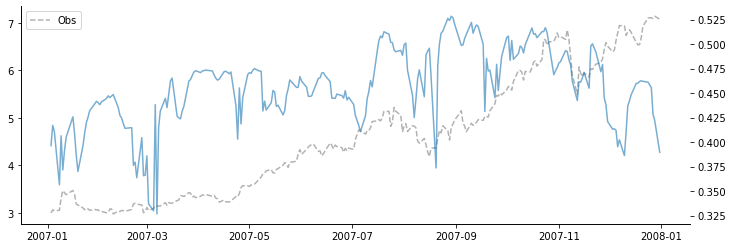

In [26]:
p = preds
time = "2007"

N = 2
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    data = preds.sel(station_id=px, time=time)

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
    ax2 = ax.twinx()
    ax2.plot(data.time, data.sim, ls="-", alpha=0.6, label=f"Sim")
    ax.legend()
    sns.despine()

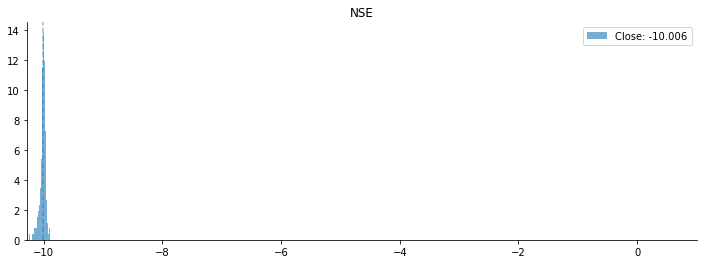

In [24]:
f, ax = plt.subplots(figsize=(12, 4))

variable = "NSE"   # Pearson-r
err = errors[variable]
ax.hist(err, bins=100, density=True, label=f"{target_var}: {err.median().values:.3f}", alpha=0.6);
ax.axvline(err.median(), ls="--", alpha=0.5)    
ax.set_title(variable)
ax.set_xlim(None, 1)
ax.legend()
sns.despine()

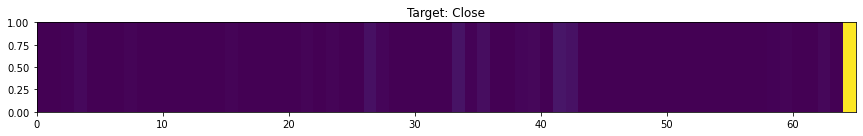

In [28]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

f, ax = plt.subplots(figsize=(12, 2))
w, b = get_model_weights(model)
ext = np.concatenate([np.abs(w), b])
plot_weights(ext, kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
ax.set_title(f"Target: {target_var}")
plt.tight_layout()